## Police stations (2019) with characteristics in Cenacom (2017) and Renadef (2017): A map

Importing relevant packages

In [1]:
import pandas as pd
import folium
import re
import numpy as np
from unicodedata import normalize

import geopandas as gpd

Opening database of police stations

In [2]:
# setting relevant paths
output = r"..\03_Output\01_Maps"

In [3]:
# openning police stations database
base = r"..\01_Data\05_Relación_de_comisarías\Relación de comisarías básicas 1318.xlsx"
comi = pd.read_excel(base, header=1, skiprows=1, dtype={"CODIGO INEI": str})

## 1. Data cleaning: police stations database

### Fixing variable names (col names)

In [4]:
print(comi.columns)
comi.rename(columns={"CODIGO INEI" : "cod_inei" ,
                   "CODIGO CPNP" : "cod_pnp" ,
                   "CODIGO CPNP" : "cod_pnp",
                   "NOMBREDD" : "departamento" ,
                   "NOMBREPP" : "provincia" ,
                   "NOMBREDI" : "distrito" ,
                   "GPS" : "gps" ,
                   "MACREGPOL/FP" : "macro_pnp" ,
                   "REGPOL" : "reg_pnp" ,
                   "DIVPOL/DIVOPUS" : "divpol_divopus" ,
                   "COMISARÍA" : "nombre" ,
                   "TIPO*" : "tipo" ,
                   "RURAL*" : "rural" ,
                   "SECTORIAL*" : "sectorial" ,
                   "ZONAL*" : "zonal" ,
                  }, 
          inplace=True)
#comi

Index(['CODIGO INEI', 'CODIGO CPNP', 'NOMBREDD', 'NOMBREPP', 'NOMBREDI', 'GPS',
       'MACREGPOL/FP', 'REGPOL', 'DIVPOL/DIVOPUS', 'COMISARÍA', 'TIPO*',
       'RURAL*', 'SECTORIAL*', 'ZONAL*', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')


### Fixing variable types 

Vars with problems: 
1. tipo: from string to categorical.
2. rural: if it's rural then rural=1 and =0 otherwise.
3. sectorial: if it's sectorial then sectorial=1 and =0 otherwise.
4. zonal: if it's zonal then zonal=1 and =0 otherwise.

In [5]:
pd.unique(comi["tipo"])

array(['A', 'D', 'B', 'C', 'E'], dtype=object)

In [6]:
comi["tipo"] = comi["tipo"].astype("category")

In [7]:
# Unique values
pd.unique(comi["rural"])
comi["rural"].value_counts(dropna=False)

X      877
NaN    441
Name: rural, dtype: int64

Looping to create a new var takes 1 when a var = "X"

In [8]:
fix = {"rural" : "rural_eli" ,
       "zonal" : "zonal_eli" ,
       "sectorial" : "sectorial_eli"}

for key,value in fix.items():
    comi[value]=np.where(comi[key] == "X", 1, 0)

In [9]:
important = ["rural", "zonal", "sectorial", "rural_eli", "zonal_eli", "sectorial_eli"]
comi.loc[comi.rural == "X", important] # OK

,rural,zonal,sectorial,rural_eli,zonal_eli,sectorial_eli
1,X,NaN,NaN,1,0,0
3,X,NaN,NaN,1,0,0
4,X,NaN,NaN,1,0,0
5,X,NaN,NaN,1,0,0
7,X,NaN,NaN,1,0,0
...,...,...,...,...,...,...
1132,X,NaN,NaN,1,0,0
1133,X,NaN,X,1,0,1
1134,X,NaN,NaN,1,0,0
1135,X,NaN,NaN,1,0,0


In [10]:
# Verifying once again
comi["rural_eli"].value_counts()

1    877
0    441
Name: rural_eli, dtype: int64

In [11]:
# Replacing values and dropping aux vars
for key,value in fix.items():
    comi[key] = comi[value]
    comi = comi.drop(columns = value)

Making sure there are no blanks in departamento, provincia, distrito and macro_pnp, and eliminating accent marks.

In [12]:
nombres = ["departamento", "provincia", "distrito", "macro_pnp"]
for columna in nombres:
    comi[columna] = comi[columna].str.upper().str.strip()
    comi[columna] = comi[columna].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")

### Merging ubigeo data

Opening data and adjusting the format based on the base of police stations database

In [13]:
# Recall principal
ubig = r"..\01_Data\UBIGEO.xls"
ubigeo = pd.read_excel(ubig, header=None, dtype=str, nrows=1874, skiprows=1, 
                       names= ["depa", "CODREG", "provi", "CODPRO", "distr", "CODDIS", "UBIGEO"])
#ubigeo

In [14]:
# There are accent marks
pd.unique(ubigeo["depa"])

array(['Amazonas', 'Áncash', 'Apurímac', 'Arequipa', 'Ayacucho',
       'Cajamarca', 'Callao', 'Cusco', 'Huancavelica', 'Huánuco', 'Ica',
       'Junín', 'La Libertad', 'Lambayeque', 'Lima', 'Loreto',
       'Madre de Dios', 'Moquegua', 'Pasco', 'Piura', 'Puno',
       'San Martín', 'Tacna', 'Tumbes', 'Ucayali'], dtype=object)

Removing blanks and accent marks in depa, provi and distr in order to match them with police station data.

In [15]:
cambiar = ["depa", "provi", "distr"]
for nombre in cambiar:
    ubigeo[nombre] = ubigeo[nombre].str.upper().str.strip()
    ubigeo[nombre] = ubigeo[nombre].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")

Merging both dataframes (ver [merge](https://stackoverflow.com/questions/41815079/pandas-merge-join-two-data-frames-on-multiple-columns)).

In [16]:
# Merging in "comi2" as an auxiliary dataframe.
comi2 = pd.merge(comi, ubigeo,  how="left", left_on=['departamento','provincia', "distrito"], 
                 right_on = ['depa','provi', "distr"], validate = "m:1", indicator = True)

In [17]:
# Checking missing values in ubigeo
comi2["UBIGEO"].value_counts(dropna=False)

NaN       26
150101    10
150132     9
021801     7
150143     6
          ..
150407     1
090501     1
080207     1
090101     1
190206     1
Name: UBIGEO, Length: 1041, dtype: int64

In [18]:
# Checking unmerged values
comi2["_merge"].value_counts()

both          1292
left_only       26
right_only       0
Name: _merge, dtype: int64

Checking left-only mergers

In [19]:
# ¿Which are those 26?
impor = ["departamento", "provincia", "distrito","depa", "provi", "distr"]
comi2.loc[comi2._merge == "left_only", impor]

,departamento,provincia,distrito,depa,provi,distr
299,CAJAMARCA,CONTUMAZA,SANTA CRUZ DE TOLED,NaN,NaN,NaN
539,ICA,NAZCA,NAZCA,NaN,NaN,NaN
540,ICA,NAZCA,MARCONA,NaN,NaN,NaN
541,ICA,NAZCA,EL INGENIO,NaN,NaN,NaN
542,ICA,NAZCA,VISTA ALEGRE,NaN,NaN,NaN
1038,SAN MARTIN,RIOJA,NUEVO CAJAMARCA,NaN,NaN,NaN
1137,CALLAO,CALLAO,CALLAO,NaN,NaN,NaN
1138,CALLAO,CALLAO,LA PUNTA,NaN,NaN,NaN
1139,CALLAO,CALLAO,CALLAO,NaN,NaN,NaN
1140,CALLAO,CALLAO,CALLAO,NaN,NaN,NaN


Therefore, values on both comi and ubigeo must be fixed for the merge to work.

In comi: 
1. "NUEVO CAJAMARCA" should be "NUEVA CAJAMARCA" (distrito en Rioja, San Martín).
2. "NAZCA" should be "NASCA" (así está en ubigeo) (distrito y provincia en Ica).
3. "SANTA CRUZ DE TOLED" should be "SANTA CRUZ DE TOLED" ("O" is missing) (distrito en Contumaza, Cajamarca).

In ubigeo:
1. "PROV. CONST. DEL CALLAO" should be "CALLAO" (provincia en el departamento Callao)

In [20]:
# In comi
comi.loc[comi.distrito  == "NUEVO CAJAMARCA", "distrito"] = "NUEVA CAJAMARCA"
comi.loc[comi.distrito  == "NAZCA", "distrito"] = "NASCA"
comi.loc[comi.provincia == "NAZCA", "provincia"] = "NASCA"
comi.loc[comi.distrito  == "SANTA CRUZ DE TOLED", "distrito"] = "SANTA CRUZ DE TOLEDO"

In [21]:
# In ubigeo
ubigeo[ubigeo["provi"]=="PROV. CONST. DEL CALLAO"]

,depa,CODREG,provi,CODPRO,distr,CODDIS,UBIGEO
689,CALLAO,07,PROV. CONST. DEL CALLAO,01,CALLAO,01,070101
690,CALLAO,07,PROV. CONST. DEL CALLAO,01,BELLAVISTA,02,070102
691,CALLAO,07,PROV. CONST. DEL CALLAO,01,CARMEN DE LA LEGUA REYNOSO,03,070103
692,CALLAO,07,PROV. CONST. DEL CALLAO,01,LA PERLA,04,070104
693,CALLAO,07,PROV. CONST. DEL CALLAO,01,LA PUNTA,05,070105
694,CALLAO,07,PROV. CONST. DEL CALLAO,01,VENTANILLA,06,070106
695,CALLAO,07,PROV. CONST. DEL CALLAO,01,MI PERU,07,070107


In [22]:
# Replacing
ubigeo.loc[ubigeo.provi == "PROV. CONST. DEL CALLAO", "provi"] = "CALLAO"

In [23]:
# A new merge
comi2 = pd.merge(comi, ubigeo,  how="left", left_on=['departamento','provincia', "distrito"], 
                 right_on = ['depa','provi', "distr"], validate = "m:1", indicator = True)

In [24]:
comi2["_merge"].value_counts() # OK

both          1318
left_only        0
right_only       0
Name: _merge, dtype: int64

In [25]:
# Replacing the original database (comi) with the auxiliary (comi2)
comi = comi2

### Geolocation of the data
Starting with the GPS data because contains latitude and longitude.

Identifying the rare data in GPS

In [26]:
# A regexp to identify "weird" values
comi[comi["gps"].str.contains("[0-9]'|[0-9]°")==True]
# just 9 values
# Careful: they don't have cod_inei.

,cod_inei,cod_pnp,departamento,provincia,distrito,gps,macro_pnp,reg_pnp,divpol_divopus,nombre,...,Unnamed: 15,Unnamed: 16,depa,CODREG,provi,CODPRO,distr,CODDIS,UBIGEO,_merge
773,NaN,1725,LORETO,UCAYALI,PAMPA HERMOSA,"-7°11'44.30,-75°17'38.60",LORETO,LORETO,DIVOPUS LORETO,CPNP PAMPA HERMOSA,...,NaN,NaN,LORETO,16,UCAYALI,06,PAMPA HERMOSA,04,160604,both
775,NaN,7905,LORETO,UCAYALI,VARGAS GUERRA,"6°54'40.9""S 75°09'26.0""W",LORETO,LORETO,DIVOPUS LORETO,CPNP ORELLANA,...,NaN,NaN,LORETO,16,UCAYALI,06,VARGAS GUERRA,06,160606,both
782,NaN,3671,MADRE DE DIOS,TAMBOPATA,LAS PIEDRAS,"-11°56'00.2"", -69°07'12.6""",MADRE DE DIOS,MADRE DE DIOS,DIVOPUS MADRE DE DIOS,CPNP MAVILA,...,NaN,NaN,MADRE DE DIOS,17,TAMBOPATA,01,LAS PIEDRAS,03,170103,both
786,NaN,3682,MADRE DE DIOS,MANU,MADRE DE DIOS,"12°47'23.2""S 70°31'19.7""W",MADRE DE DIOS,MADRE DE DIOS,DIVOPUS MADRE DE DIOS,CPNP DELTA 1,...,NaN,NaN,MADRE DE DIOS,17,MANU,02,MADRE DE DIOS,03,170203,both
787,NaN,3683,MADRE DE DIOS,TAMBOPATA,INAMBARI,"-12.926243°,-70.302720°",MADRE DE DIOS,MADRE DE DIOS,DIVOPUS MADRE DE DIOS,CPNP SANTA ROSA,...,NaN,NaN,MADRE DE DIOS,17,TAMBOPATA,01,INAMBARI,02,170102,both
880,NaN,7925,UCAYALI,ATALAYA,SEPAHUA,"11°08'41.4""S 73°02'41.5""W",PUERTO INCA,PUERTO INCA,DIVOPUS PI,CPNP SEPAHUA,...,NaN,NaN,UCAYALI,25,ATALAYA,02,SEPAHUA,02,250202,both
958,NaN,1444,AMAZONAS,BONGARA,CHURUJA,"-6.020006°,-77.952163°",SAN MARTIN,SAN MARTIN,DIVOPUS AMAZONAS,CPNP CHURUJA,...,NaN,NaN,AMAZONAS,01,BONGARA,03,CHURUJA,03,010303,both
1015,NaN,1393,SAN MARTIN,TOCACHE,UCHIZA,"-8°20'34.00,-76°23'14.20",SAN MARTIN,SAN MARTIN,DIVOPUS TARAPOTO,CPNP SANTA LUCIA,...,NaN,NaN,SAN MARTIN,22,TOCACHE,10,UCHIZA,05,221005,both
1109,NaN,7900,UCAYALI,CORONEL PORTILLO,MASISEA,"-8.605750°,-74.305806°",UCAYALI,UCAYALI,DIVOPUS UCAYALI,CPNP MASISEA,...,NaN,NaN,UCAYALI,25,CORONEL PORTILLO,01,MASISEA,04,250104,both


In [27]:
# Some of the "weirds"
comi["gps"][[2,773,800]]

2      -9.52707907,-77.53541276
773    -7°11'44.30,-75°17'38.60
800    -5.34800031,-80.71298264
Name: gps, dtype: object

After looking through each of them, they will be replaced with the right values

In [28]:
# Replacing

dictio = {773 : "-7.1956389,-75.29405555555556" ,
          775 : "-6.9113611,-75.15722222222223" ,
          782 : "-11.9333889,-69.12016666666666" ,
          786 : "-12.7897778,-70.52213888888889" ,
          787 : "-12.926243,-70.302720" ,
          880 : "-11.1448333,-74.0448611111111" ,
          958 : "-6.020006,-77.952163",
          1015 : "-8.342778,-76.38728" ,
          1109 : "-8.605750,-74.305806"
         }

for key in dictio:
    comi.at[key, "gps"] = dictio[key]

In [29]:
# Verifying
comi["gps"][[773,775]]
comi[comi["gps"].str.contains("[0-9]'|[0-9]°")==True]

,cod_inei,cod_pnp,departamento,provincia,distrito,gps,macro_pnp,reg_pnp,divpol_divopus,nombre,...,Unnamed: 15,Unnamed: 16,depa,CODREG,provi,CODPRO,distr,CODDIS,UBIGEO,_merge


In [30]:
# Looking if there's a valus with spaces
comi[comi["gps"].str.contains("\s")==True]

,cod_inei,cod_pnp,departamento,provincia,distrito,gps,macro_pnp,reg_pnp,divpol_divopus,nombre,...,Unnamed: 15,Unnamed: 16,depa,CODREG,provi,CODPRO,distr,CODDIS,UBIGEO,_merge


After cleaning gps, it remains to separate long and lat into two different variables. 

In [31]:
# Spliting gps and creating an auxiliary dataframe
new = comi["gps"].str.split(",", n = 1, expand = True)

In [32]:
# Adding lat and long to comi
comi["lat"] = new[0]
comi["long"] = new[1]

## Plotting the police stations on the map with *folium*

Creating the map centered in Peru

In [33]:
# Map of Peru
m = folium.Map(location=[-12.0453, -77.0311], zoom_start=5)

Plotting lat and long using a loop and CircleMarker function from folium.
**NOTE**: markers like CircleMarker usually accept tuples.

In [34]:
# Looping with tuples
for index, row in comi.iterrows():
    folium.CircleMarker(
        location = (row["lat"], row["long"]) ,
        popup = row["nombre"],
        radius = 5,
        color = "blue",
        fill = True,
        fill_color = "#3186cc",
        fill_opacity = 0.7
    ).add_to(m)

In [35]:
m.save(output+"\police_stations.html")
#m

## Adding features to police stations with Cenacom (2017)

Opening Cenacom data.
There are 1,495 police stations in Cenacom. It may contain special units (unidades especiales-UE).

In [36]:
mod1226 = r"..\01_Data\01_Cenacom\2017\595-Modulo1226\Cap_100_Infraestructura 2017.sav"
cena1226 = pd.read_spss(mod1226)
cena1226

,ID_N,UBIGEO,CCDI,NOMBREDI,INF109,INF109A,INF109A_O,INF109B1,INF109C1_D1,INF109C1_D2,...,INF126_10,INF126_11,INF126_12,INF126_13,INF126_14,INF126_15,INF126_16,INF126_O,GPSLATITUD_INF,GPSLONGITUD_INF
0,0001,100601,01,RUPA-RUPA,De 40001 - 80000 Hab,Distrital,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-9.29806953,-76.00260836
1,0002,100606,06,MARIANO DAMASO BERAUN,De 5000 - 10000 Hab,Distrital,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-9.49461342,-75.95306846
2,0003,100604,04,JOSE CRESPO Y CASTILLO,De 20001 - 40000 Hab,Distrital,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-8.93140901,-76.11188986
3,0004,221001,01,TOCACHE,De 5000 - 10000 Hab,Provincial,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-8.1884396,-76.51227108
4,0005,221002,02,NUEVO PROGRESO,De 5000 - 10000 Hab,Distrital,,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-8.45341229,-76.3241724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,9075,200101,01,PIURA,De 20001 - 40000 Hab,Regional,,1.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-5.19367149,-80.63275722
1491,9076,030109,09,TAMBURCO,Menos de 5000 Hab,Regional,,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-13.62197143,-72.87277891
1492,9077,180301,01,ILO,De 80001 a más Hab,Regional,,1.0,18.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-17.64451236,-71.34384742
1493,9078,100101,01,HUANUCO,De 20001 - 40000 Hab,Regional,,1.0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,-9.93362881,-76.23916271


In [37]:
cena1226.dtypes

ID_N                 object
UBIGEO               object
CCDI                 object
NOMBREDI             object
INF109             category
                     ...   
INF126_15          category
INF126_16          category
INF126_O             object
GPSLATITUD_INF       object
GPSLONGITUD_INF      object
Length: 280, dtype: object

Fixing relevant variables to make a merge with police station data

In [38]:
cena1226["UBIGEO"]   = cena1226["UBIGEO"].astype("string")
cena1226["NOMBREDI"] = cena1226["NOMBREDI"].str.upper().str.strip()
cena1226["NOMBREDI"] = cena1226["NOMBREDI"].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")

In [39]:
# Droping _merge from the last merge in comi
comi = comi.drop(columns = "_merge")

Merging Cenacom (cena1226) with police station data (comi) in an auxiliary dataframe (comi3)

In [40]:
comi3 = pd.merge(comi, cena1226, how="right", left_on=["UBIGEO", "cod_inei", "lat", "long"], 
                 right_on = ["UBIGEO", "ID_N", "GPSLATITUD_INF", "GPSLONGITUD_INF"], validate = "1:1", indicator = True)

Looking for unmerged obs

In [41]:
comi3["_merge"].value_counts()

both          1304
right_only     191
left_only        0
Name: _merge, dtype: int64

Adjusting the 191 values so that they can be plotted. They might be special units.

In [42]:
comi3["aux"] = "UE" # unidad especial
comi3.loc[comi3._merge == "right_only", "nombre"]=comi3.aux.str.cat(comi3.NOMBREDI, sep= " ")
comi3.loc[comi3._merge == "right_only", "lat"]=comi3["GPSLATITUD_INF"]
comi3.loc[comi3._merge == "right_only", "long"]=comi3["GPSLONGITUD_INF"]
comi3.loc[comi3._merge == "right_only", "distrito"]=comi3["NOMBREDI"]

In [43]:
# dropping aux variable
comi3 = comi3.drop(columns = "aux")

In [44]:
# Replacing comi with the merged and adjusted dataframe
comi=comi3

### Plotting police stations with number of police officers - Cenacom (2017)

The variable of interest for this module is
**INF110_TOT**, which means (¿CUÁNTOS POLICÍAS ESTÁN ASIGNADOS EN LA COMISARÍA? - TOTAL1).

In [45]:
comi["INF110_TOT"]=comi["INF110_TOT"].astype("int")

<AxesSubplot:>

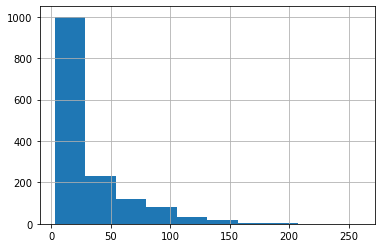

In [46]:
comi["INF110_TOT"].hist()

Plotting police stations with a tooltip for number of police officers

In [47]:
for index, row in comi.iterrows():
    folium.CircleMarker(
        location = (row["lat"], row["long"]) ,
        tooltip = row["nombre"],
        popup = "Policías" + " " + str(row["INF110_TOT"]) ,        
        radius = 5,
        color = "blue",
        fill = True,
        fill_color = "#3186cc",
        fill_opacity = 0.7
    ).add_to(m)

# saving map with number of officers in each police station
m.save(output+"\cenacom_officers.html")
#m